<a href="https://colab.research.google.com/github/abhimanyubhowmik/Underwater_Depth_Estimation/blob/main/initial_scripts/SQUID_with_Deep_Anything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import os
import cv2
import random
import matplotlib.pyplot as plt
import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-o0yfjb_g
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-o0yfjb_g
  Resolved https://github.com/huggingface/transformers.git to commit ce4fff0be7f6464d713f7ac3e0bbaafbc6959ae5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

# SQUID Data

In [ ]:
!rm -r /content/SQUID

In [ ]:
!unzip /content/drive/MyDrive/SQUIDData/SQUID.zip

Archive:  /content/drive/MyDrive/SQUIDData/SQUID.zip
   creating: SQUID/
  inflating: SQUID/.DS_Store         
  inflating: __MACOSX/SQUID/._.DS_Store  
   creating: SQUID/Images/
   creating: SQUID/DistanceMap/
  inflating: SQUID/Images/LFT_04.tif  
  inflating: __MACOSX/SQUID/Images/._LFT_04.tif  
  inflating: SQUID/Images/LFT_05.tif  
  inflating: __MACOSX/SQUID/Images/._LFT_05.tif  
  inflating: SQUID/Images/LFT_07.tif  
  inflating: __MACOSX/SQUID/Images/._LFT_07.tif  
  inflating: SQUID/Images/LFT_06.tif  
  inflating: __MACOSX/SQUID/Images/._LFT_06.tif  
  inflating: SQUID/Images/LFT_02.tif  
  inflating: __MACOSX/SQUID/Images/._LFT_02.tif  
  inflating: SQUID/Images/.DS_Store  
  inflating: __MACOSX/SQUID/Images/._.DS_Store  
  inflating: SQUID/Images/LFT_03.tif  
  inflating: __MACOSX/SQUID/Images/._LFT_03.tif  
  inflating: SQUID/Images/LFT_01.tif  
  inflating: __MACOSX/SQUID/Images/._LFT_01.tif  
  inflating: SQUID/Images/LFT_08.tif  
  inflating: __MACOSX/SQUID/Images/._LF

In [ ]:
def print_random_images(directory_path, k, rows, cols):
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp','tif'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select k random images
    selected_images = image_files[:k]

    # Create a grid to display the images
    fig, axes = plt.subplots(rows, cols, figsize=(rows*5, cols*2))

    # Loop through the grid and plot images
    for i in range(rows):
        for j in range(cols):
            # If there are no more images to display, break out of the loop
            if not selected_images:
                break
            # Load and display the image
            img_path = os.path.join(directory_path, selected_images.pop())
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(os.path.basename(img_path))

    # Show the plot
    plt.show()

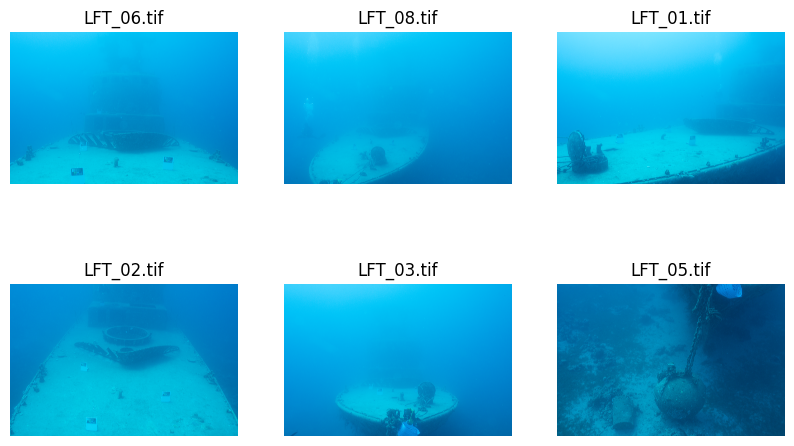

In [ ]:
print_random_images('/content/SQUID/Images', k=6, rows=2, cols=3)

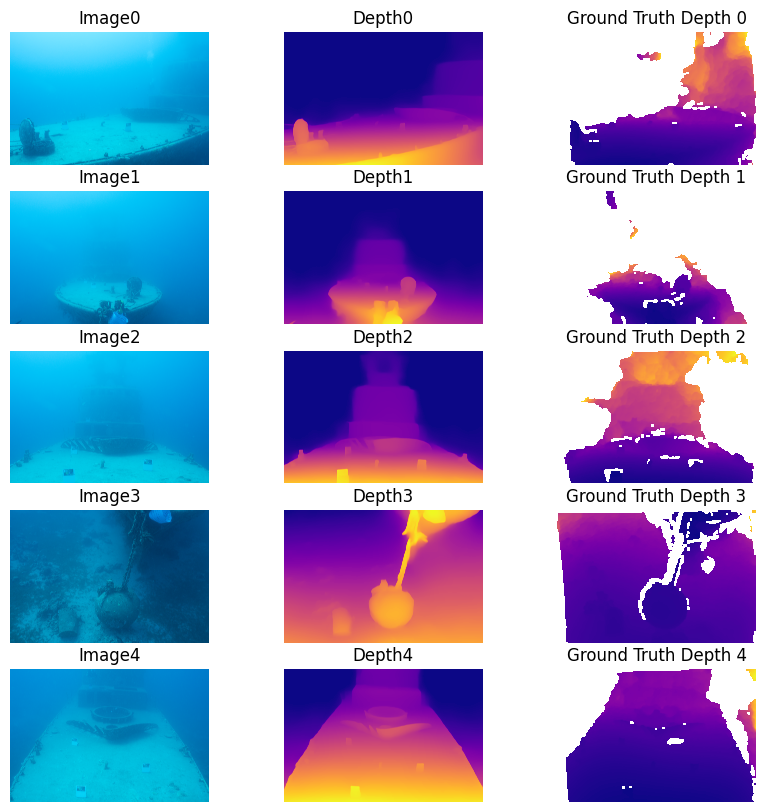

In [ ]:
def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image


def depth_estimation_seaThru(directory_path, k, model, image_processor):
    # Get a list of all files in the directory
    dir_path = os.path.join(directory_path,'Images')
    files = os.listdir(dir_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp','.tif'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select k random images
    selected_images = image_files[:k]

    # Create a grid to display the images
    fig, axes = plt.subplots(k, 3, figsize=(10, 2*k))

    for i, img_file in enumerate(selected_images):
        # Load the original image
        img_path = os.path.join(directory_path,'Images', img_file)
        assert os.path.exists(img_path)

        original_image = Image.open(img_path)
        original_image_display = cv2.imread(img_path)

        img_lab = cv2.cvtColor(original_image_display,cv2.COLOR_BGR2Lab)
        l,a,b = cv2.split(img_lab)

        clahe = cv2.createCLAHE(clipLimit=50, tileGridSize=(8, 8))
        lumen_clahe = clahe.apply(l)
        equ = cv2.equalizeHist(l)

        updated_lab_img = cv2.merge((lumen_clahe,a,b))

        original_image_display = cv2.cvtColor(updated_lab_img,cv2.COLOR_LAB2LBGR)

        # Prepare image for the model
        inputs = image_processor(images=original_image, return_tensors="pt")

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=original_image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )

        # Convert depth prediction to numpy array
        depth_output = prediction.squeeze().cpu().numpy()

        # Plot original image
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image{i}',)

        # Plot depth output
        axes[i, 1].imshow(depth_output,cmap = 'plasma')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Depth{i}')

        # Load ground truth depth from TIFF file
        gt_mat_file = img_file.replace('LFT_0', 'distance')
        gt_mat_file = gt_mat_file.replace('.tif', '.mat')
        gt_mat_path = os.path.join(directory_path, 'DistanceMap', gt_mat_file)
        gt_mat_data = scipy.io.loadmat(gt_mat_path)
        dist_map_l = gt_mat_data['dist_map_l']
        # gt_depth_array = np.array(dist_map_l)
        # gt_depth_normalized = min_max_normalize(gt_depth_array)


        # Plot ground truth depth
        axes[i, 2].imshow(dist_map_l, cmap='plasma')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f'Ground Truth Depth {i}')


    plt.show()

depth_estimation_seaThru('/content/SQUID/',k=5, model=model, image_processor=image_processor)


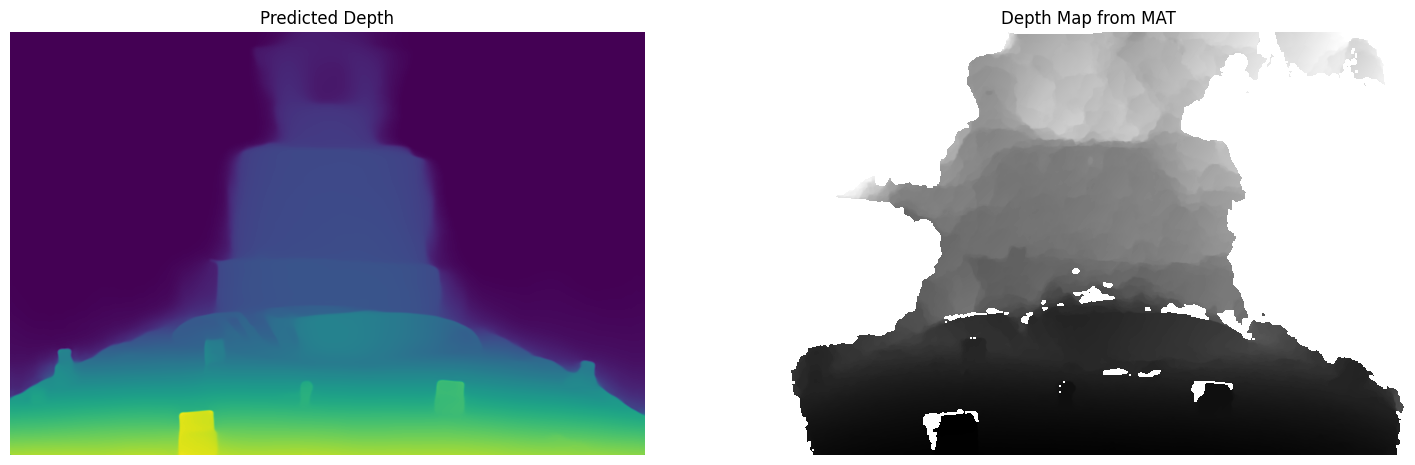

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def visualize_tiff(tiff_path):
    # Open the TIFF image using PIL
    img = Image.open(tiff_path)

    # Convert to numpy array
    img_array = np.array(img)

    # Normalize the image using min-max normalization
    img_normalized = min_max_normalize(img_array)

    return img_normalized

# Load the original image and predict depth
original_image = Image.open('/content/SQUID/Images/LFT_06.tif')
inputs = image_processor(images=original_image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Interpolate to original size and convert to numpy array
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=original_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
depth_output = prediction.squeeze().cpu().numpy()

# Visualize the TIFF image and predicted depth side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


# Plot depth output and label it
axes[0].imshow(depth_output)
axes[0].set_title('Predicted Depth')
axes[0].axis('off')

# Visualize the TIFF image and label it
mat_path = '/content/SQUID/DistanceMap/distance6.mat'
gt_mat_data = scipy.io.loadmat(mat_path)
dist_map_l = gt_mat_data['dist_map_l']

axes[1].imshow(dist_map_l, cmap='gray')
axes[1].set_title('Depth Map from MAT')
axes[1].axis('off')

plt.show()

In [ ]:
def reduce_outliers_normalize(image):
    # Get the 5th and 95th percentiles
    bottom_percentile = np.percentile(image, 5)
    top_percentile = np.percentile(image, 95)

    # Clip the pixel values to the 5th and 95th percentiles
    clipped_image = np.clip(image, bottom_percentile, top_percentile)

    # Get the minimum and maximum pixel values after clipping
    min_val = np.min(clipped_image)
    max_val = np.max(clipped_image)

    # Normalize the clipped image
    normalized_image = (clipped_image - min_val) / (max_val - min_val)
    return normalized_image

In [ ]:
img_tiff = Image.open('/content/D5/depth/depthLFT_3374.tif')
img_array_tiff = np.array(img_tiff)
img_normalized_tiff = min_max_normalize(img_array_tiff)

non_zero_mask = img_array_tiff != 0



# plt.hist(depth_output.ravel(),bins = 200,histtype='step', label= 'Output')
# plt.hist(img_array_tiff[non_zero_mask].ravel(),bins = 200, histtype='step',label = 'Ground Truth')

histr1 = cv2.calcHist([min_max_normalize(depth_output)],[0],None,[256],[0,1])
histr2 = cv2.calcHist([img_normalized_tiff[non_zero_mask]],[0],None,[256],[0,1])

eq_hist1 = cv2.equalizeHist(histr1.astype(np.uint8))
eq_hist2 = cv2.equalizeHist(histr2.astype(np.uint8))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(histr1,label= 'Output')
plt.plot(histr2,label = 'Ground Truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eq_hist1,label= 'Output Equalized')
plt.plot(eq_hist2,label = 'Ground Truth Equalized')
plt.legend()
_ = plt.show()

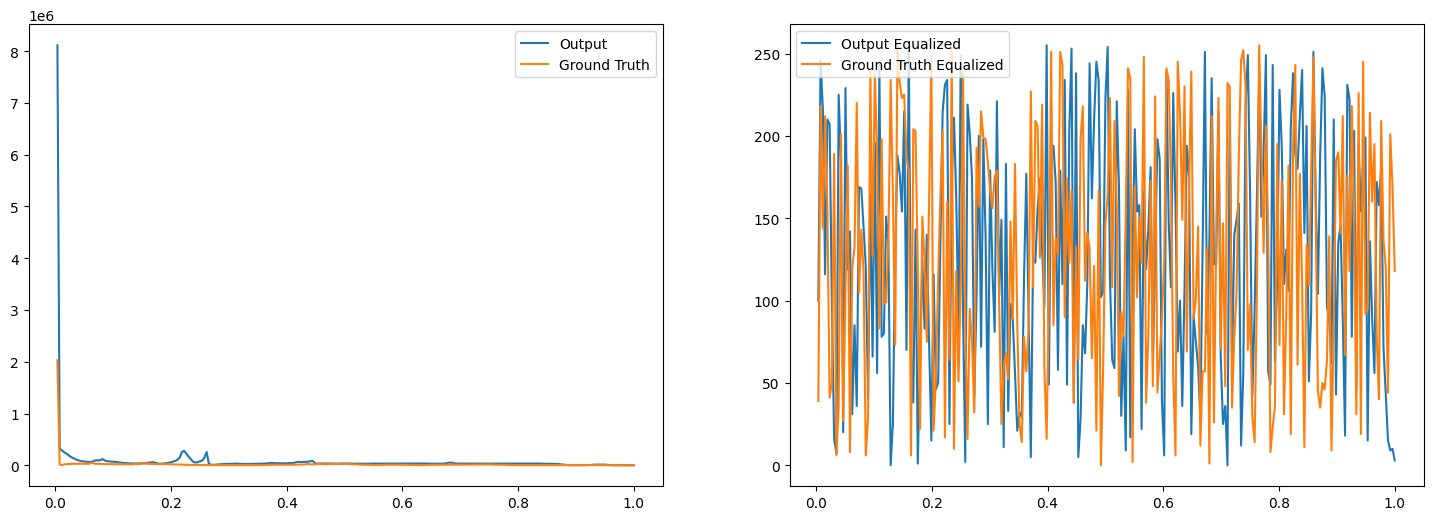

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the .mat file
mat_path = '/content/SQUID/DistanceMap/distance6.mat'
gt_mat_data = scipy.io.loadmat(mat_path)
dist_map_l = gt_mat_data['dist_map_l']

# Handle NaN values by replacing them with zero
#dist_map_l = np.nan_to_num(dist_map_l)
dist_map_l = dist_map_l.astype(np.float32)

img_normalized_mat = min_max_normalize(dist_map_l)

gt_mask = dist_map_l != 0
# depth_output_mask = depth_output != 0

# # Apply masks to ground truth and depth output
# gt_nonzero = dist_map_l[gt_mask]
# depth_output_nonzero = depth_output[depth_output_mask]

# Calculate histogram using numpy
histr1 = cv2.calcHist([min_max_normalize(depth_output)],[0],None,[256],[0,1])
histr2 = cv2.calcHist([img_normalized_mat[gt_mask]],[0],None,[256],[0,1])

# Equalize histograms
eq_hist1 = cv2.equalizeHist(histr1.astype(np.uint8))
eq_hist2 = cv2.equalizeHist(histr2.astype(np.uint8))

# Plot histograms
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(bin_edges1[1:], histr1, label='Output')
plt.plot(bin_edges2[1:], histr2, label='Ground Truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bin_edges1[1:], eq_hist1, label='Output Equalized')
plt.plot(bin_edges2[1:], eq_hist2, label='Ground Truth Equalized')
plt.legend()
plt.show()


nan
3.2965302
nan


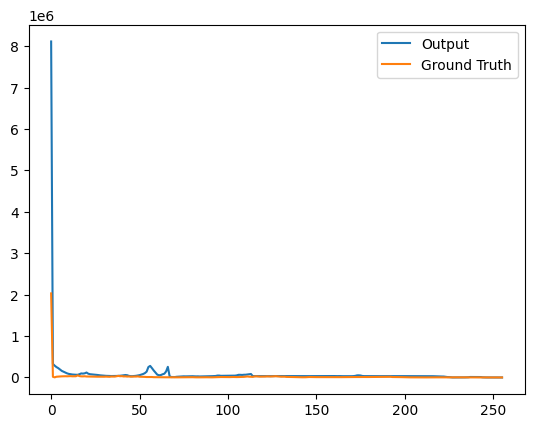

In [ ]:
def scale_offset_invariance(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    print(mean1)
    print(mean2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - mean2

    print(offset)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset

    return depth_map2_adjusted

scale_offset_invariance_depth_output = scale_offset_invariance(img_normalized_mat[gt_mask], depth_output)

histr1_inv = cv2.calcHist([scale_offset_invariance_depth_output],[0],None,[256],[0,1])
histr2 = cv2.calcHist([img_normalized_mat[gt_mask]],[0],None,[256],[0,1])


plt.plot(histr1,label= 'Output')
plt.plot(histr2,label = 'Ground Truth')
plt.legend()

<ipython-input-76-035a64b5bd22>:7: RuntimeWarning: invalid value encountered in cast
  equalized_ground_truth = cv2.equalizeHist(dist_map_l.astype(np.uint8))


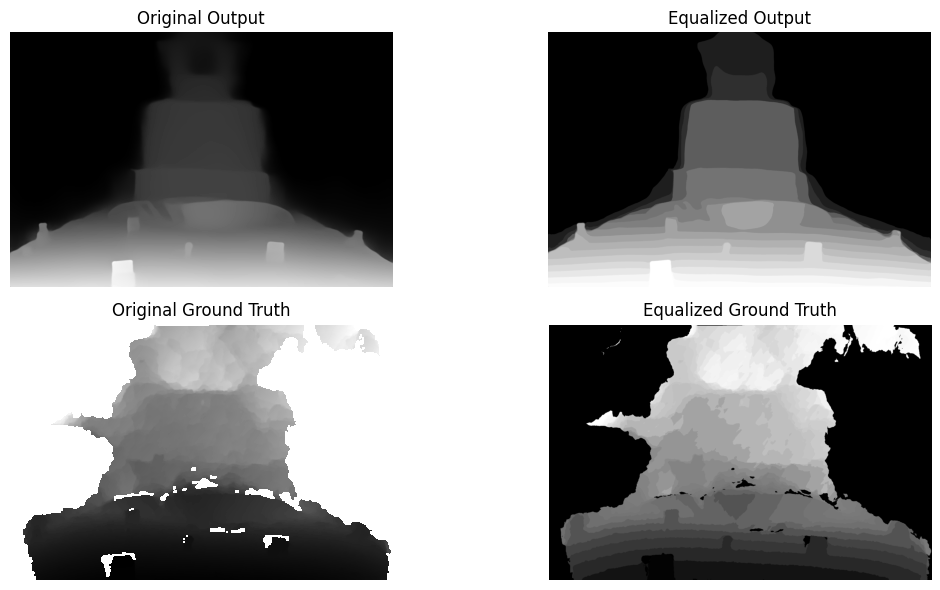

In [ ]:
mat_path = '/content/SQUID/DistanceMap/distance6.mat'
gt_mat_data = scipy.io.loadmat(mat_path)
dist_map_l = gt_mat_data['dist_map_l']

# Apply histogram equalization to both images
equalized_depth_output = cv2.equalizeHist(depth_output.astype(np.uint8))
equalized_ground_truth = cv2.equalizeHist(dist_map_l.astype(np.uint8))

gt_mask = dist_map_l != 0

# Calculate histograms
histr1 = cv2.calcHist([equalized_depth_output],[0],None,[256],[0,20])
histr2 = cv2.calcHist([img_normalized_mat[gt_mask]],[0],None,[256],[0,20])

# Plotting
plt.figure(figsize=(12, 6))

# Original and equalized output image
plt.subplot(2, 2, 1)
plt.imshow(depth_output, cmap='gray')
plt.title('Original Output')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(equalized_depth_output, cmap='gray')
plt.title('Equalized Output')
plt.axis('off')

# Original and equalized ground truth image
plt.subplot(2, 2, 3)
plt.imshow(dist_map_l, cmap='gray')
plt.title('Original Ground Truth')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(equalized_ground_truth, cmap='gray')
plt.title('Equalized Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def scale_offset_invariance_psnr(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - (scale_factor * mean2)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset


    #Calculate the PSNR
    psnr_val = psnr(depth_map1, depth_map2_adjusted)

    return psnr_val


def scale_offset_invariance_ssim(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - (scale_factor * mean2)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset

    # Calculate the SSIM
    ssim_value, _ = ssim(depth_map1, depth_map2_adjusted, full=True)

    return ssim_value

In [ ]:
def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image


def depth_estimation_seaThru(directory_path, k, model, image_processor):
    # Get a list of all files in the directory
    dir_path = os.path.join(directory_path,'Images')
    files = os.listdir(dir_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp','.tif'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select k random images
    selected_images = image_files[:k]

    # Create a grid to display the images
    fig, axes = plt.subplots(k, 3, figsize=(10, 2*k))

    for i, img_file in enumerate(selected_images):
        # Load the original image
        img_path = os.path.join(directory_path,'Images', img_file)
        assert os.path.exists(img_path)

        original_image = Image.open(img_path)
        original_image_display = cv2.imread(img_path)

        img_lab = cv2.cvtColor(original_image_display,cv2.COLOR_BGR2Lab)
        l,a,b = cv2.split(img_lab)

        clahe = cv2.createCLAHE(clipLimit=50, tileGridSize=(8, 8))
        lumen_clahe = clahe.apply(l)
        equ = cv2.equalizeHist(l)

        updated_lab_img = cv2.merge((lumen_clahe,a,b))

        original_image_display = cv2.cvtColor(updated_lab_img,cv2.COLOR_LAB2LBGR)

        # Prepare image for the model
        inputs = image_processor(images=original_image, return_tensors="pt")

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=original_image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )

        # Convert depth prediction to numpy array
        depth_output = prediction.squeeze().cpu().numpy()

        # Plot original image
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image{i}',)

        # Plot depth output
        axes[i, 1].imshow(depth_output,cmap = 'plasma')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Depth{i}')

        # Load ground truth depth from TIFF file
        gt_mat_file = img_file.replace('LFT_0', 'distance')
        gt_mat_file = gt_mat_file.replace('.tif', '.mat')
        gt_mat_path = os.path.join(directory_path, 'DistanceMap', gt_mat_file)
        gt_mat_data = scipy.io.loadmat(gt_mat_path)
        dist_map_l = gt_mat_data['dist_map_l']


        # Plot ground truth depth
        axes[i, 2].imshow(dist_map_l, cmap='plasma')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f'Ground Truth Depth {i}')


    plt.show()

depth_estimation_seaThru('/content/SQUID/',k=5, model=model, image_processor=image_processor)


In [ ]:
import os
import random
import pandas as pd
import torch
import numpy as np
import scipy.stats
from PIL import Image

def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def calculate_metrics(directory_path, k, model, image_processor):
    results = []

    # Get a list of all files in the directory
    dir_path = os.path.join(directory_path, 'Images')
    files = os.listdir(dir_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp','.tif'))]

    # Load ground truth depth from TIFF file
    gt_depth_array = {}
    for img_file in image_files:
        gt_mat_file = img_file.replace('LFT_0', 'distance')
        gt_mat_file = gt_mat_file.replace('.tif', '.mat')
        gt_mat_path = os.path.join(directory_path, 'DistanceMap', gt_mat_file)
        gt_mat_data = scipy.io.loadmat(gt_mat_path)
        dist_map_l = gt_mat_data['dist_map_l']
        dist_map_l = np.nan_to_num(dist_map_l)
        gt_depth_array[img_file] = dist_map_l.astype(np.float32)

    # Shuffle the list of image files
    random.shuffle(image_files)

    for i, img_file in enumerate(image_files[:k]):
        # Load the original image
        img_path = os.path.join(directory_path, 'Images', img_file)
        assert os.path.exists(img_path)
        original_image = Image.open(img_path)

        # Prepare image for the model
        inputs = image_processor(images=original_image, return_tensors="pt")

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=original_image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )

        # Convert depth prediction to numpy array and resize to match ground truth depth map size
        depth_output = prediction.squeeze().cpu().numpy()
        gt_depth_normalized = min_max_normalize(gt_depth_array[img_file])
        depth_output_resized = np.array(Image.fromarray(depth_output).resize(gt_depth_normalized.shape[::-1]))

        # Handle invalid or unexpected depth values
        depth_output_resized[depth_output_resized <= 0] = 1e-7  # Replace negative or zero values with a small epsilon

        # Calculate metrics
        non_zero_mask = gt_depth_normalized != 0
        absrel = np.mean(np.abs(depth_output_resized[non_zero_mask] - gt_depth_normalized[non_zero_mask]) / gt_depth_normalized[non_zero_mask])

        d = np.log(gt_depth_normalized + 1e-7) - np.log(depth_output_resized + 1e-7)
        silog = np.mean(np.square(d)) - np.square(np.sum(d))/ np.square(d.size)
        pearson_corr = scipy.stats.pearsonr(depth_output_resized.flatten(), gt_depth_normalized.flatten())[0]
        #psnr_val = psnr(gt_depth_normalized, depth_output_resized, data_range=depth_output_resized.max() - depth_output_resized.min())
        #ssim_val = ssim(gt_depth_normalized, depth_output_resized, data_range=depth_output_resized.max() - depth_output_resized.min())

        psnr_val = scale_offset_invariance_psnr(gt_depth_normalized,depth_output_resized)
        ssim_val = scale_offset_invariance_ssim(gt_depth_normalized,depth_output_resized)

        results.append({
            'Image': i,
            'Absolute Relative error (AbsRel)': absrel,
            'Scale Invarience MSE (Logscale)': silog,
            'Pearson Correlation': pearson_corr,
            'PSNR (Scale and offset Invarience)': psnr_val,
            'SSIM (Scale and offset Invarience)': ssim_val
        })

    return pd.DataFrame(results)


# Example usage:
# Replace '/content/D5' with the directory path containing your images and depth maps
metrics_df = calculate_metrics('/content/SQUID', k=5, model=model, image_processor=image_processor)
print(metrics_df)


   Image  Absolute Relative error (AbsRel)  Scale Invarience MSE (Logscale)  \
0      0                         21.736864                        42.990198   
1      1                         28.801579                        17.713486   
2      2                         18.905687                        44.075121   
3      3                         33.864296                        61.086634   
4      4                         28.222729                        37.648211   

   Pearson Correlation  PSNR (Scale and offset Invarience)  \
0             0.003825                            6.962136   
1            -0.488890                           14.285444   
2             0.043185                           12.209430   
3            -0.240035                           13.875191   
4             0.060152                            9.027469   

   SSIM (Scale and offset Invarience)  
0                            0.638705  
1                            0.721020  
2                            0.4

In [ ]:
metrics_df

,Image,Absolute Relative error (AbsRel),Scale Invarience MSE (Logscale),Pearson Correlation,PSNR (Scale and offset Invarience),SSIM (Scale and offset Invarience)
0,0,21.736864,42.990198,0.003825,6.962136,0.638705
1,1,28.801579,17.713486,-0.488890,14.285444,0.721020
2,2,18.905687,44.075121,0.043185,12.209430,0.491886
3,3,33.864296,61.086634,-0.240035,13.875191,0.505888
4,4,28.222729,37.648211,0.060152,9.027469,0.665210
